In [324]:
import openpyxl
from openpyxl import load_workbook
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
from sklearn.linear_model import LinearRegression
import math
from scipy import stats
import scipy
import matplotlib.dates as mdate
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import warnings

# Data Preprocessing

In [325]:
filepath="/content/Table_10.5__Solar_Energy_Consumption.xlsx"

In [326]:
# retrieve data
solar_data=[]
time_data=[]
data=pd.read_excel(filepath, sheet_name="Monthly Data")

# find the position of col of 'Solar Energy Consumption'
target_value = 'Solar Energy Consumption'
matching_rows_col = np.where(data.isin([target_value]))
target_col=int(matching_rows_col[1])

# find the position of 'Month'
time_value="Month"
matching_row_cols_time = np.where(data.isin([time_value]))
Month_col=int(matching_row_cols_time[1])
Month_row=int(matching_row_cols_time[0])

#retrieve target data frame
ts_data=data.iloc[Month_row:,[Month_col,target_col]].dropna()
ts_data=ts_data.reset_index(drop=True)
ts_data.columns=ts_data.iloc[0,:]
ts_data=ts_data.drop(0)


# na proportion
na_proportion=ts_data[ts_data["Solar Energy Consumption"]=="Not Available"].shape[0]/ts_data.shape[0]
print(f"na proportion in raw data:{na_proportion}")

#remove "Not Available" data
ts_data=ts_data[ts_data["Solar Energy Consumption"]!="Not Available"]

# set Month as index
ts_data=ts_data.set_index("Month")
ts_data.columns=["consumption"]


na proportion in raw data:0.21710526315789475


# EDA

1. Retrieve data starting from 2012, because the trend of solar energy consumption in previous years is not robust
2. Set 90% data as trainning data and remaining 10% data as testing data

statistics information of data since 1984
       consumption
count   476.000000
mean     12.310538
std      17.571500
min       0.000000
25%       3.830000
50%       5.518500
75%      10.210000
max      97.397000
proportion of data after 2012:0.29411764705882354
statistics information of data since 2012
       consumption
count   476.000000
mean     12.310538
std      17.571500
min       0.000000
25%       3.830000
50%       5.518500
75%      10.210000
max      97.397000
final number of data is 476


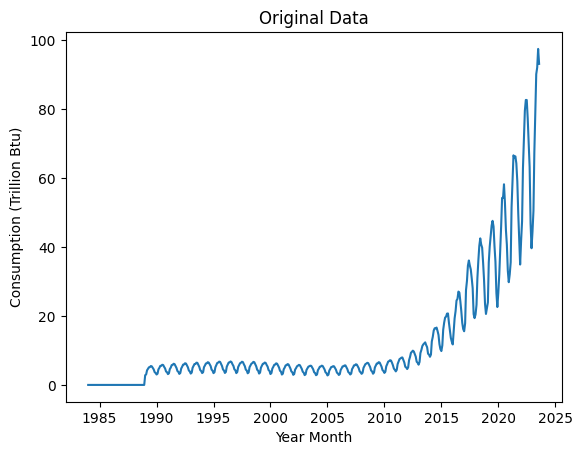

In [327]:
# describe statistics
ts_data["consumption"]=pd.to_numeric(ts_data["consumption"])
print(f"statistics information of data since 1984")
print(ts_data.describe())

# ts plot
plt.plot(ts_data.index, ts_data['consumption'])
plt.xlabel('Year Month')
plt.ylabel('Consumption (Trillion Btu)')
plt.title('Original Data')

# proportion of data after 2012
print(f"proportion of data after 2012:{ts_data[ts_data.index >= '2012-01-01'].shape[0]/ts_data.shape[0]}")
print(f"statistics information of data since 2012")
print(ts_data.describe())
print(f"final number of data is {ts_data.shape[0]}")

Text(0.5, 1.0, 'Original Data')

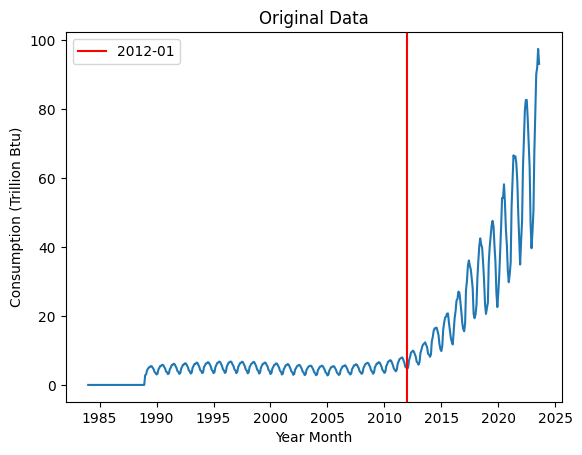

In [328]:
plt.plot(ts_data.index, ts_data['consumption'])
plt.xlabel('Year Month')
plt.ylabel('Consumption (Trillion Btu)')
plt.axvline(pd.Timestamp('2012-01-01'), color='r', linestyle='-',label="2012-01")
plt.legend()
plt.title('Original Data')

Select data from after 2012

In [329]:
ts_data=ts_data[ts_data.index >= '2012-01-01']

Text(0.5, 1.0, 'Trimmed Data')

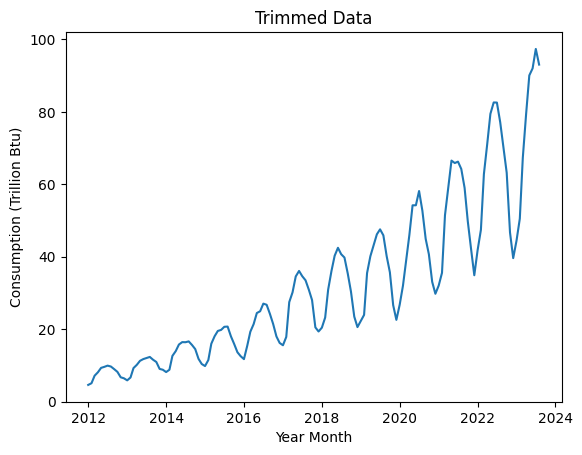

In [330]:
# plot trimmed data
plt.plot(ts_data.index, ts_data['consumption'])
plt.xlabel('Year Month')
plt.ylabel('Consumption (Trillion Btu)')
plt.title('Trimmed Data')

In [331]:
# split data into trainning data and testing data
split_index = math.ceil(len(ts_data)*0.9)
print(f"number of trainning data after 2012 is {split_index}")
print(f"number of testing data after 2012 is {len(ts_data)-split_index}")
training_data=ts_data.iloc[:split_index,:]
testing_data=ts_data.iloc[split_index:,:]

number of trainning data after 2012 is 126
number of testing data after 2012 is 14


In [332]:
training_data.head(3)

,consumption
Month,
2012-01-01,4.607
2012-02-01,5.077
2012-03-01,7.148


In [333]:
testing_data.head(3)

,consumption
Month,
2022-07-01,82.584
2022-08-01,77.169
2022-09-01,70.105


# 2. Data Analysis

We notice that the variance increase.
## 2.1. Transformation method

### 2.1.1 Box-Cox transformation

Text(0.5, 1.0, 'Training data after Box-Cox transformation')

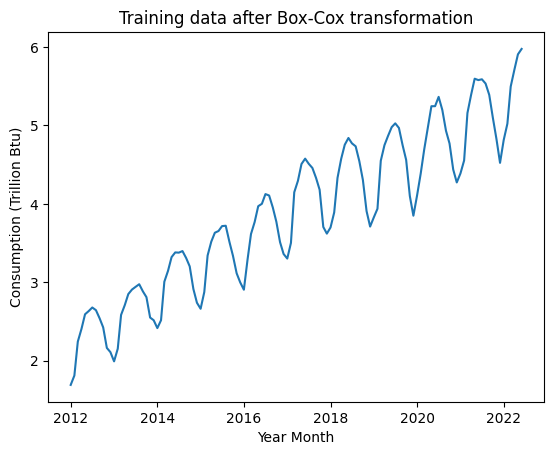

In [334]:
consumption, fitted_lambda = stats.boxcox(training_data['consumption'])
# training_data['consumption'] = consumption
plt.plot(training_data.index, consumption)
plt.xlabel('Year Month')
plt.ylabel('Consumption (Trillion Btu)')
plt.title("Training data after Box-Cox transformation")


### 2.1.2 Log transformation

Text(0.5, 1.0, 'Training data after Log transformation')

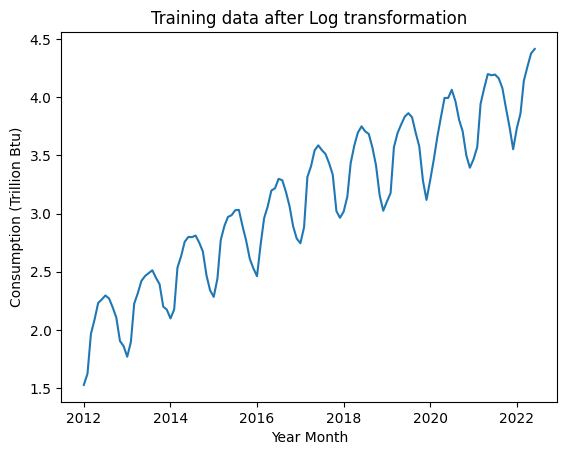

In [335]:
plt.plot(np.log(training_data['consumption']))
plt.xlabel('Year Month')
plt.ylabel('Consumption (Trillion Btu)')
plt.title("Training data after Log transformation")


### 2.1.3 Selecting transformation method
Log transformation better than Box-Cox due to the range of y-axis (consumption value)

In [336]:
training_data['consumption'] = np.log(training_data['consumption'])

<ipython-input-336-f861d385c2c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['consumption'] = np.log(training_data['consumption'])


## 2.2. Analyzing the “smooth” component

According to the box cox transformed plot above, there is clearly pattern for trend and seasonality, i.e. yt = mt + st + xt.

### 2.2.1. Moving average methods

<ipython-input-337-9307e2c6a2b9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['moving_avg'] = training_data['consumption'].rolling(window=13, center=True).apply(weighted_average, raw=True)


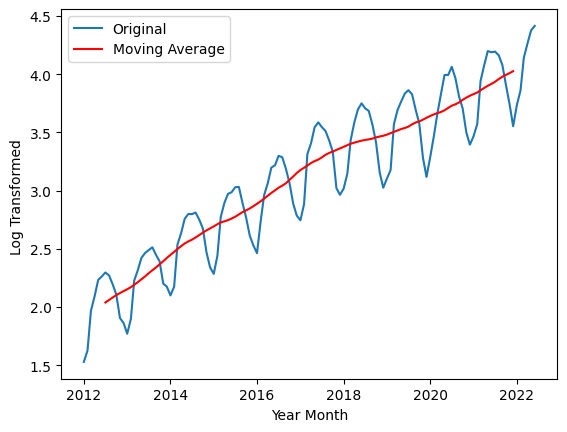

In [337]:
# step 1: detrend
weights = np.array([.5])
weights = np.append(weights, np.repeat(1, 11))
weights = np.append(weights, .5)

def weighted_average(window):
  if len(window) != len(weights):
    return np.nan
  return (window * weights).sum() / 12

training_data['moving_avg'] = training_data['consumption'].rolling(window=13, center=True).apply(weighted_average, raw=True)

# Plot the original and moving average for comparison
# plt.figure(figsize=(10, 6))
plt.plot(training_data['consumption'], label='Original')
plt.plot(training_data['moving_avg'], label='Moving Average', color='red')
plt.xlabel('Year Month')
plt.ylabel('Log Transformed ')
plt.legend()
plt.show()

<ipython-input-338-98bc36ef5081>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['detrended'] = training_data['consumption'] - training_data['moving_avg']


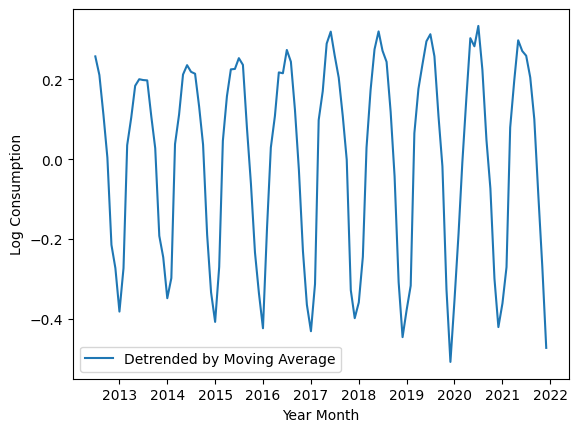

In [338]:
# Subtract the moving average from the original data
training_data['detrended'] = training_data['consumption'] - training_data['moving_avg']

# Plot the detrended data
plt.plot(training_data['detrended'], label='Detrended by Moving Average')
plt.legend()
plt.xlabel('Year Month')
plt.ylabel('Log Consumption')
plt.show()

In [339]:
training_data.tail(10)

,consumption,moving_avg,detrended
Month,,,
2021-09-01,4.077978,3.977634,0.100344
2021-10-01,3.907573,3.993631,-0.086058
2021-11-01,3.739620,4.008721,-0.269100
2021-12-01,3.552344,4.025530,-0.473187
2022-01-01,3.733088,NaN,NaN
2022-02-01,3.859592,NaN,NaN
2022-03-01,4.140051,NaN,NaN
2022-04-01,4.263693,NaN,NaN
2022-05-01,4.375241,NaN,NaN


<ipython-input-340-e9a86c77bbcf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['month'] = training_data.index.month
<ipython-input-340-e9a86c77bbcf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['seasonal'] = training_data['month'].map(seasonal_component)


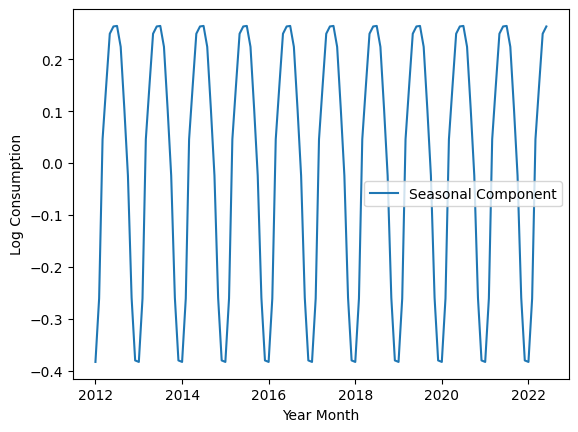

In [340]:
# step 2: deseasonalize

# Map the seasonal component to each corresponding month in the original dataframe
training_data['month'] = training_data.index.month
seasonal_component = training_data.groupby('month')['detrended'].mean()
training_data['seasonal'] = training_data['month'].map(seasonal_component)

# Plot to see the seasonal component over time
plt.plot(training_data['seasonal'], label='Seasonal Component')
plt.legend()
plt.xlabel('Year Month')
plt.ylabel('Log Consumption')
plt.show()


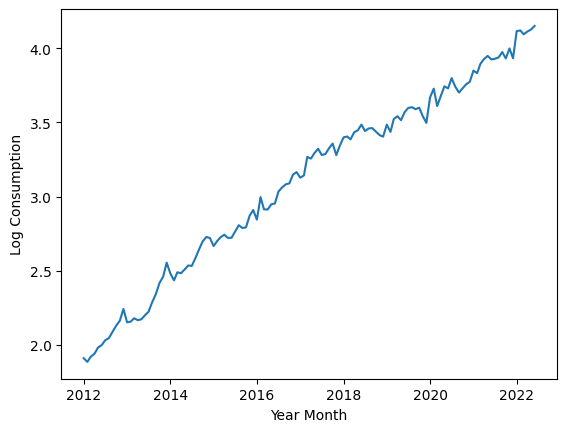

Degree 1:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     7405.
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          1.96e-112
Time:                        08:14:28   Log-Likelihood:                 137.49
No. Observations:                 126   AIC:                            -271.0
Df Residuals:                     124   BIC:                            -265.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0266      0.015    139.69

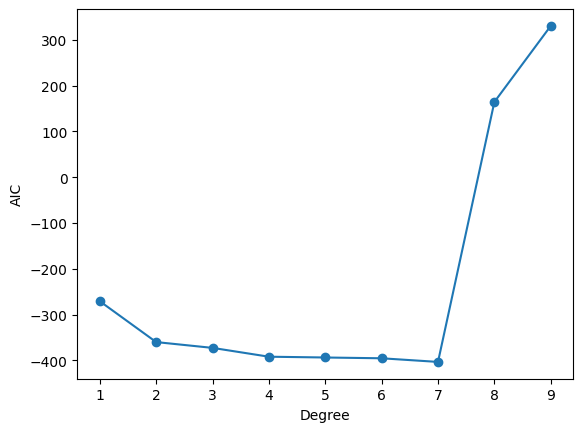

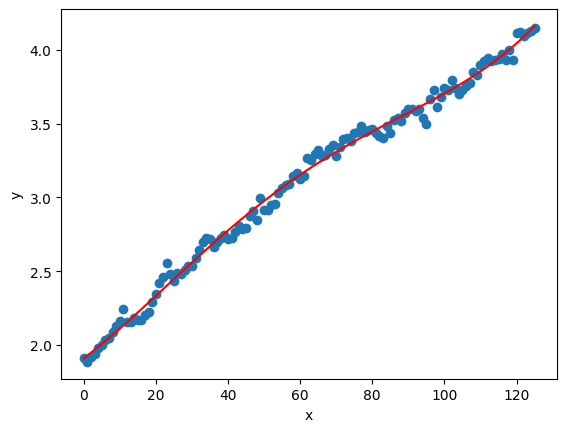

In [341]:
# step 3: detrend again
import statsmodels.api as sm

deseason = training_data['consumption'] - training_data['seasonal']

plt.plot(deseason)
plt.ylabel('Log Consumption')
plt.xlabel('Year Month')
plt.show()

# Define predictor and response variables
x = np.arange(len(training_data))
y = deseason
# Create a range of degrees to test
degrees = range(1, 10)

# Initialize an empty list to store the AIC values
aic_values = []

# Loop over the degrees
for d in degrees:
    # Fit a polynomial regression model of degree d
    model = sm.OLS(y, sm.add_constant(np.column_stack([x**i for i in range(1, d+1)]))).fit()
    # Append the AIC value to the list
    aic_values.append(model.aic)
    # Print the model summary
    print(f"Degree {d}:")
    print(model.summary())
    print()

# Find the index of the minimum AIC value
min_index = np.argmin(aic_values)

# Print the optimal degree
print(f"The optimal degree is {degrees[min_index]} with AIC = {aic_values[min_index]}")

# Plot the AIC values vs the degrees
plt.plot(degrees, aic_values, marker='o')
plt.xlabel('Degree')
plt.ylabel('AIC')
plt.show()

# Combining results of AIC, adj. R-squred, and p-value of the hypothesis test for beta coefficient=0,
# we pick the degree = 4
design_mat = sm.add_constant(np.column_stack([x**i for i in range(1, 5)]))
poly4model = sm.OLS(y, design_mat).fit()
trend_est = poly4model.predict(design_mat)

# Plot the data and the fitted model of the optimal degree
plt.scatter(x, y)
plt.plot(x, trend_est, color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<ipython-input-342-da424a4f1bb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['residual'] = deseason - trend_est


Text(0.5, 1.0, 'residuals')

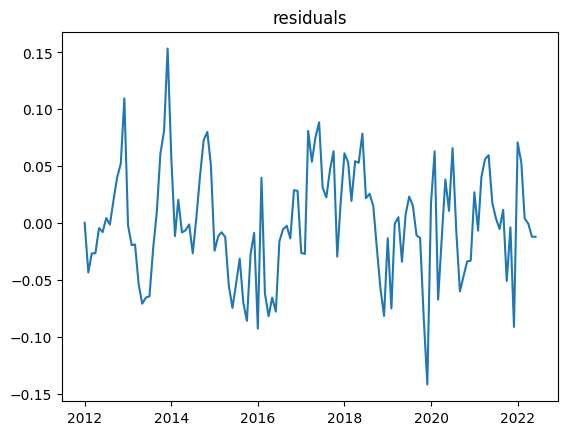

In [342]:
training_data['residual'] = deseason - trend_est
plt.plot(training_data['residual'])
plt.title('residuals')

### 2.2.1. ADF Test for stationarity

In [343]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(training_data['residual'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpretation
if result[1] > 0.05:
    print("Possibly significant trend (Fail to reject H0)")
else:
    print("No significant trend (Reject H0)")

ADF Statistic: -6.264452525445032
p-value: 4.146734402977443e-08
No significant trend (Reject H0)


### 2.2.2 Check mean and variance of residuals group by year

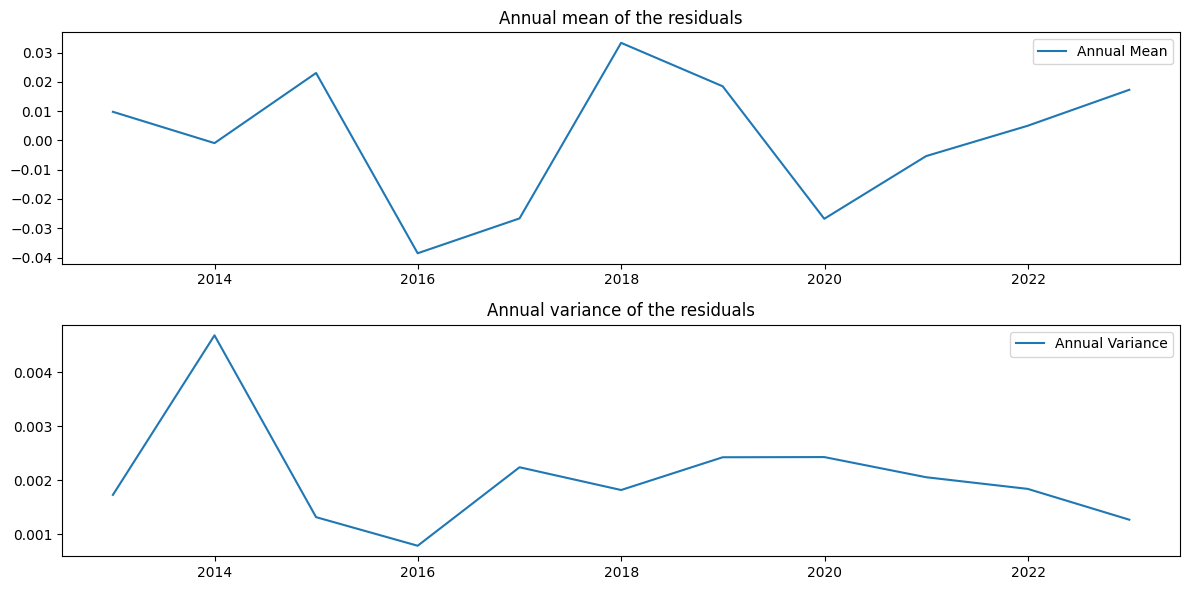

In [344]:
annual_mean = training_data['residual'].resample('Y').mean()
annual_variance = training_data['residual'].resample('Y').var()

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(annual_mean, label='Annual Mean')
plt.title('Annual mean of the residuals')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(annual_variance, label='Annual Variance')
plt.title('Annual variance of the residuals')
plt.legend()

plt.tight_layout()
plt.show()

## 2.3. Assessing residuals

According the results from the sample ACF plot, we can see there are definitely way more than 5% of the ACF values that are outside the 95% confidence interval.

These indicate that the residuals are not independent and we need to fit some models for the residuals further.

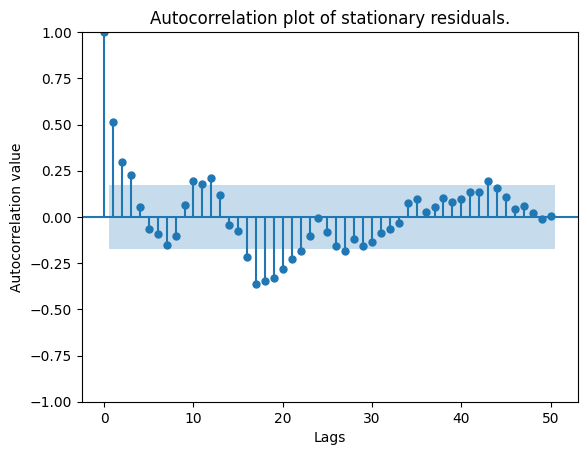

In [345]:
import statsmodels.api as sm
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(training_data['residual'].dropna(), bartlett_confint=False,lags=50,ax=ax)
ax.set_xlabel("Lags")
ax.set_ylabel("Autocorrelation value")
ax.set_title("Autocorrelation plot of stationary residuals.")
plt.show()


In [346]:
# Check normality: Shapiro-Wilk Test (p-value>0.05) do not reject H0: data is not significantly different from normal.
shapiro_test = stats.shapiro(training_data['residual'].dropna())
if shapiro_test[1] > 0.05:
  print("residuals are not significantly different from normal.")
else:
  print("residuals are significantly different from normal.")

residuals are not significantly different from normal.


Text(0.5, 1.0, 'L-jung Box of stationary residuals')

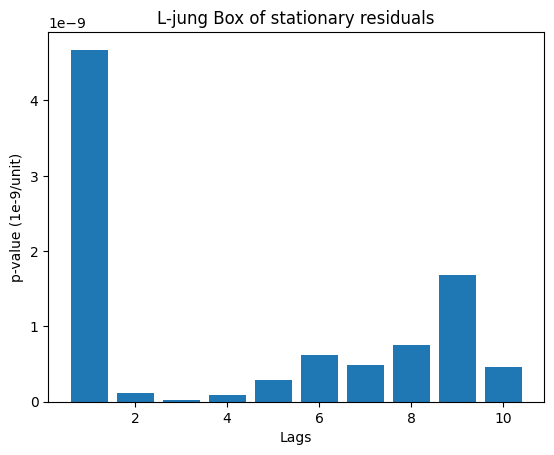

In [347]:
# Check dependency:L-jung Box (p-value>0.05) H0: data is not significant dependent
L_jung_box=acorr_ljungbox(training_data['residual'].dropna(),return_df=True)
plt.bar(L_jung_box.index,L_jung_box["lb_pvalue"])
plt.xlabel("Lags")
plt.ylabel("p-value (1e-9/unit)")
plt.title("L-jung Box of stationary residuals")


## 2.4. Analyzing the “rough” component

From the ACF plot above, the ACFs tail off as lags increase. This suggests that we could try an AR or a ARMA model. Next we inspect the PACF plot to further assit our decison on whether the model should be a simple AR or ARMA. It looks like we can try with AR(8) and ARMA(p, q) p=1,...,8, q=0,..,3

In [348]:
from statsmodels.graphics.tsaplots import plot_acf

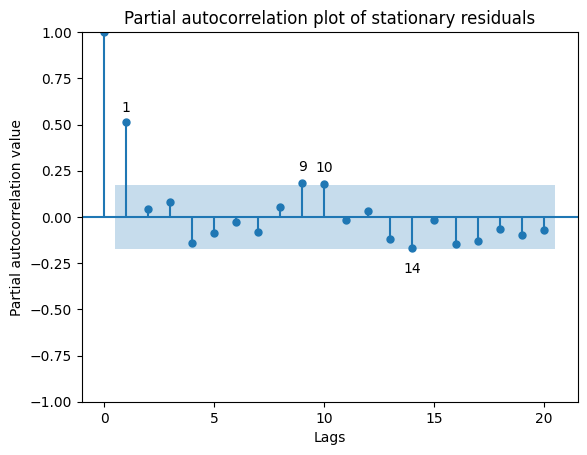

In [349]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

fig, ax = plt.subplots()
plot_pacf(training_data['residual'], ax=ax, lags=20)

# Calculate PACF values
pacf_values = pacf(training_data['residual'], nlags=20)

# Label specific lags
lags_to_label = [1,9,10,14]

for lag in lags_to_label:
    pacf_value = pacf_values[lag]
    if pacf_value>=0:
      ax.annotate(f'{lag}', xy=(lag, pacf_value), xytext=(lag, pacf_value + 0.05),
                ha='center')  # Horizontal alignment
    else:
      ax.annotate(f'{lag}', xy=(lag, pacf_value), xytext=(lag, pacf_value - 0.1),
                ha='center')

ax.set_xlabel("Lags")
ax.set_ylabel("Partial autocorrelation value")
ax.set_title("Partial autocorrelation plot of stationary residuals")

plt.show()


### 2.4.1. Proposed AR model

AR(1) has the smallest AIC of -434.822

In [350]:
aic_values = []
lags = [1, 9, 10, 14]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for lag in lags:
      model = sm.tsa.ARIMA(training_data['residual'].dropna(), order=(lag, 0,0))
      model_fit = model.fit()
      aic_values.append(model_fit.aic)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_lag = lags[aic_values.index(min(aic_values))]
    model = sm.tsa.ARIMA(training_data['residual'].dropna(), order=( best_lag, 0,0))
    result = model.fit()
    print(result.summary())


                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                  126
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 220.411
Date:                Wed, 06 Dec 2023   AIC                           -434.822
Time:                        08:14:35   BIC                           -426.313
Sample:                    01-01-2012   HQIC                          -431.365
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.008     -0.013      0.990      -0.015       0.015
ar.L1          0.5120      0.062      8.282      0.000       0.391       0.633
sigma2         0.0018      0.000      8.207      0.0

Text(0, 0.5, 'value')

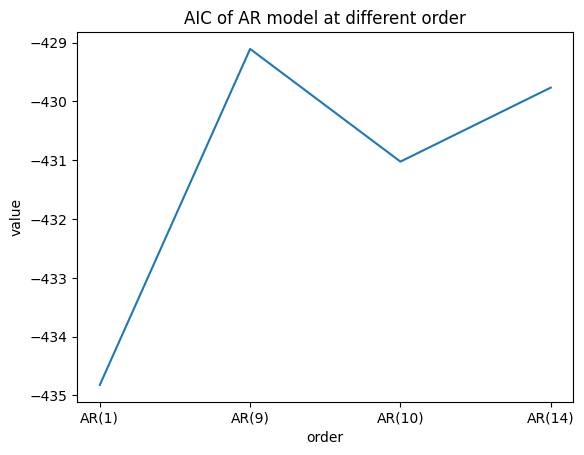

In [351]:
# plot AIC value of AR(1), AR(9), AR(10), AR(14)
plt.plot(range(1,5),aic_values)
plt.xticks(ticks=[1, 2, 3,4], labels=['AR(1)', 'AR(9)', 'AR(10)', 'AR(14)'])
plt.title("AIC of AR model at different order")
plt.xlabel("order")
plt.ylabel("value")

Text(0.5, 1.0, 'L-jung Box of residuals after fitting AR(1) model')

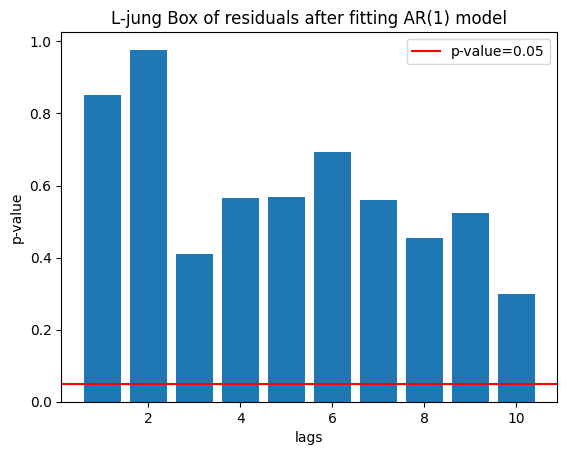

In [352]:
# Test for residual independence
L_jung_box=acorr_ljungbox(result.resid.dropna(),return_df=True)
L_jung_box
plt.bar(L_jung_box.index,L_jung_box["lb_pvalue"])
plt.xlabel("lags")
plt.ylabel("p-value")
plt.axhline(y=0.05, color='r', linestyle='-',label="p-value=0.05")
plt.legend()
plt.title("L-jung Box of residuals after fitting AR(1) model")


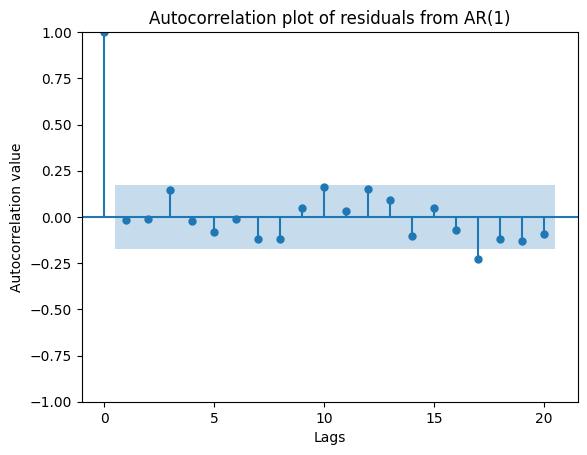

In [353]:
# plot acf of residuals from AR(1) model
fig, ax = plt.subplots()
plot_acf(result.resid.dropna(), ax=ax, lags=20,bartlett_confint=False)
ax.set_title("Autocorrelation plot of residuals from AR(1)")
ax.set_xlabel("Lags")
ax.set_ylabel("Autocorrelation value")

plt.show()

### 2.4.2. Proposed models ARMA(p, q) where p=1,...,5, q=1,..5

1. based on Prob(Q), we learn that the p-vlaue is 0.81 and it exceeds 0.05, there is no dependence in residual.

In [354]:
import warnings

In [355]:
def best_arma(p,q):
  aic=np.zeros(shape=(p+1,q+1))
  for p in range(1,p+1):
    for q in range(1,q+1):
      # Fit ARMA model with identified orders
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = sm.tsa.ARIMA(training_data['residual'].dropna(), order=(p, 0,q))
        fitted_model = model.fit()
        aic[p, q] = fitted_model.aic

  pq_min = np.unravel_index(aic.argmin(), aic.shape)
  best_p=pq_min[0]
  best_q=pq_min[1]

  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = sm.tsa.ARIMA(training_data['residual'].dropna(), order=(best_p, 0, best_q))
    fitted_model = model.fit()
    print(fitted_model.summary())
    residuals = fitted_model.resid
    print(residuals.describe())

  L_jung_box=acorr_ljungbox(residuals.dropna(),return_df=True)
  L_jung_box

  # plot L_jung_box
  plt.bar(L_jung_box.index,L_jung_box["lb_pvalue"])
  plt.xlabel("lags")
  plt.ylabel("p-value")
  plt.axhline(y=0.05, color='r', linestyle='-',label="p-value=0.05")
  plt.legend()
  plt.title(f"L-jung Box of residuals from ARMA({best_p},{best_q}) model")
  plt.show()

  # plot residual of ARMA model
  plt.plot(fitted_model.resid)
  plt.title(f"residuals of ARMA({best_p}, {best_q})")
  plt.show()

  # plot ACF of residuals from ARMA model
  fig, ax = plt.subplots()
  sm.graphics.tsa.plot_acf(fitted_model.resid, bartlett_confint=False)
  plot_acf(result.resid.dropna(), ax=ax, lags=20,bartlett_confint=False)
  ax.set_title(f"Autocorrelation plot of residuals from ARMA({best_p},{best_q})")
  ax.set_xlabel("Lags")
  ax.set_ylabel("Autocorrelation value")

  plt.show()
  print(aic)
  return best_p, best_q

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                  126
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 225.204
Date:                Wed, 06 Dec 2023   AIC                           -436.408
Time:                        08:14:52   BIC                           -416.554
Sample:                    01-01-2012   HQIC                          -428.342
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.008     -0.283      0.777      -0.017       0.013
ar.L1          1.4097      0.177      7.973      0.000       1.063       1.756
ar.L2         -0.7407      0.151     -4.906      0.0

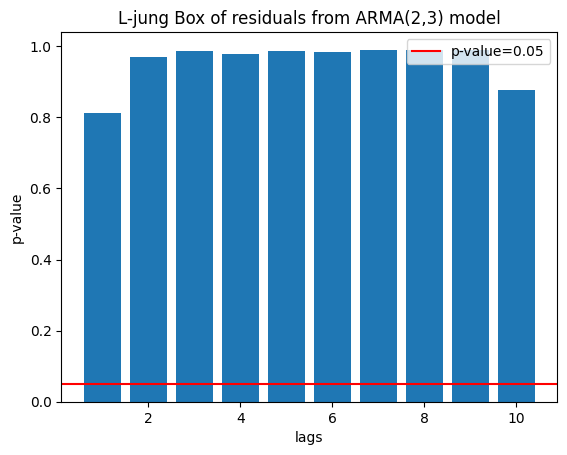

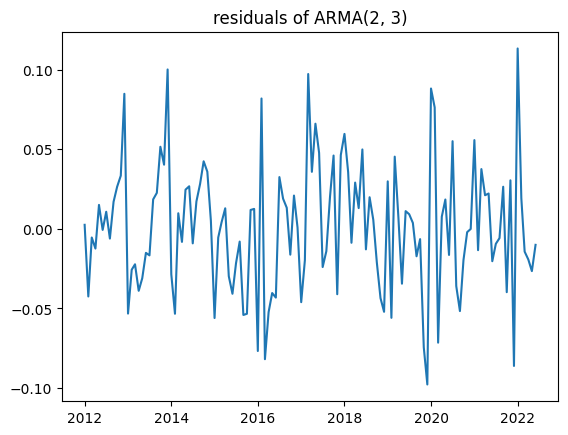

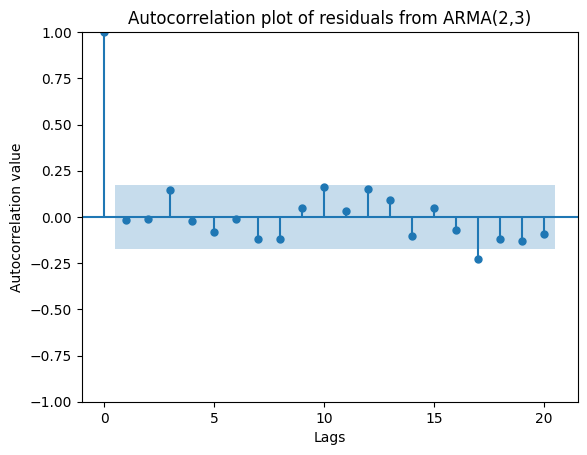

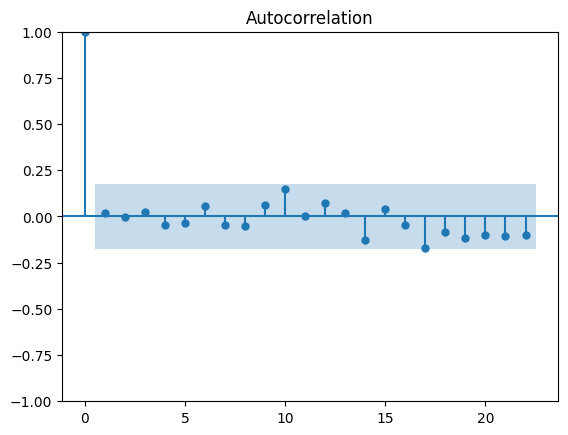

[[   0.            0.            0.            0.            0.
     0.        ]
 [   0.         -433.09239258 -431.25953606 -431.78109354 -430.28222596
  -428.34854765]
 [   0.         -431.12590272 -429.97156956 -436.40757044 -434.97489863
  -431.32229433]
 [   0.         -430.59682383 -429.78168608 -434.6636666  -433.68020723
  -430.66173158]
 [   0.         -431.2425336  -432.23150799 -434.09111013 -431.77199912
  -431.62747508]
 [   0.         -429.10168539 -427.44077221 -425.2759804  -424.07804171
  -430.33814815]]


In [356]:
best_p, best_q=best_arma(5,5)

### 2.4.3. Model Selection

ARMA(2,3) has a smaller AIC=-436.4 than AR(1) AIC=-434.822, we pick ARMA.


## 2.5. Predict future values



## 2.5.1. Forecast future Log transformed solar energy



1.  Use poly4model to predict future trend
2.  Use the seasonal component aligned with the corresponding future month.
3.  Use np.exp() to reverse the value, which is the sum of the value from the ARMA(2,3) model, future trend, and seasonal component.

consumption

y = m + s + x

### (a) Future trend estimation

In [357]:
forecast_x=np.arange(len(training_data)+1,len(training_data)+1+len(testing_data))
design_mat = sm.add_constant(np.column_stack([forecast_x**i for i in range(1, 5)]))
trend_est = poly4model.predict(design_mat)

### (b) Sum up value from ARMA(2,3), trend estimation, and seasonal component

In [358]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = sm.tsa.ARIMA(training_data['residual'].dropna(), order=(best_p, 0,best_q))
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=testing_data.shape[0])
    print(forecast)
    ## 2102
    y = forecast['2022-07-01':] + np.array(training_data.loc['2012-07-01':'2013-08-01', 'seasonal']) + trend_est
    ## 2017
    #y =  forecast+ np.array(training_data.loc['2018-01-01':'2018-08-01', 'seasonal']) + trend_est

2022-07-01   -0.013838
2022-08-01   -0.022399
2022-09-01   -0.024876
2022-10-01   -0.019181
2022-11-01   -0.009319
2022-12-01    0.000365
2023-01-01    0.006712
2023-02-01    0.008484
2023-03-01    0.006282
2023-04-01    0.001864
2023-05-01   -0.002732
2023-06-01   -0.005938
2023-07-01   -0.007053
2023-08-01   -0.006251
Freq: MS, Name: predicted_mean, dtype: float64


### (c) Transform back the prediction by np.exp(y)

In [359]:
forecasted_consumption = np.exp(y)

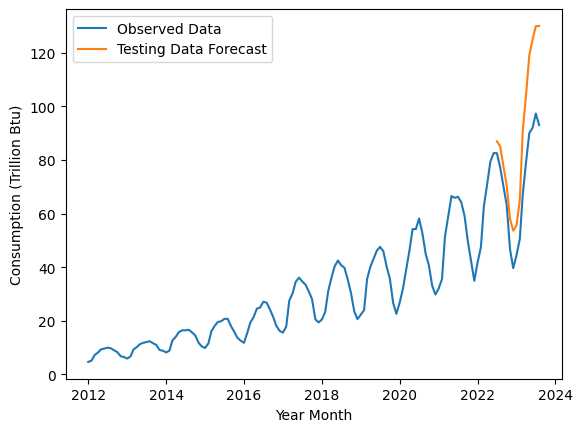

In [360]:
plt.plot(ts_data, label='Observed Data')
plt.plot(forecasted_consumption, label = 'Testing Data Forecast')
plt.xlabel('Year Month')
plt.ylabel('Consumption (Trillion Btu)')
plt.legend()
plt.show()

### 2.5.2. Check Prediction Accuracy

14
MAE: 18.50218921411844
MSE: 459.0689912996918
RMSE: 21.425895344178542


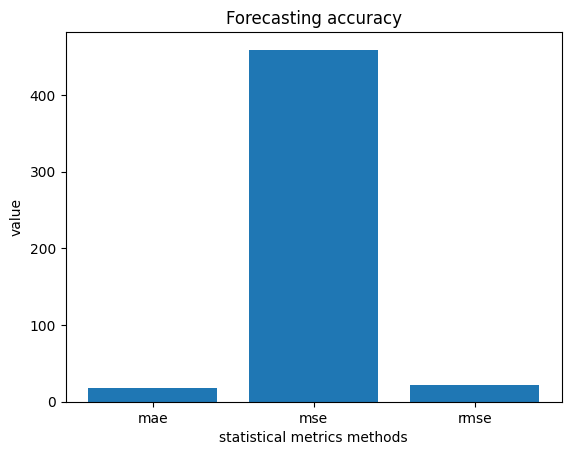

In [361]:
y_true = ts_data.loc["2022-07-01":,"consumption"]  #2012
#y_true = ts_data.loc["2023-01-01":,"consumption"] #2017
y_pred = forecasted_consumption
print(y_pred .shape[0])

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
accuracy={"mae":mae,"mse":mse,"rmse":rmse}

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

plt.bar(accuracy.keys(),accuracy.values())
plt.xlabel("statistical metrics methods")
plt.ylabel("value")
plt.title("Forecasting accuracy")
plt.show()

In [362]:
# Adding a constant for the intercept
X = sm.add_constant(y_pred)
model = sm.OLS(y_true, X)
results = model.fit()

print("R-squared:", results.rsquared)

R-squared: 0.9019652511840688


### 2.5.3. 2030 solar energy consumption prediction

In [363]:
# create sesonal component from 2022-07 to 2030-12
a=training_data.loc["2012-07-01":"2012-12-01","seasonal"]
b=training_data.loc["2012-01-01":"2012-12-01","seasonal"]
b=np.repeat(b,8)
seasonal_2030=np.append(a,b)

In [364]:
# forecaste trend from 2022-07 to 2030-12
forecast_x=np.arange(len(training_data)+1,len(training_data)+1+102)
design_mat = sm.add_constant(np.column_stack([forecast_x**i for i in range(1, 5)]))
trend_est = poly4model.predict(design_mat)

In [365]:
# forecaste residuals from 2022-07 to 2030-12
forecast = fitted_model.forecast(steps=102)

In [366]:
y=forecast+trend_est+seasonal_2030

In [367]:
future_val=np.exp(y)

Text(0, 0.5, 'solar energy consumption')

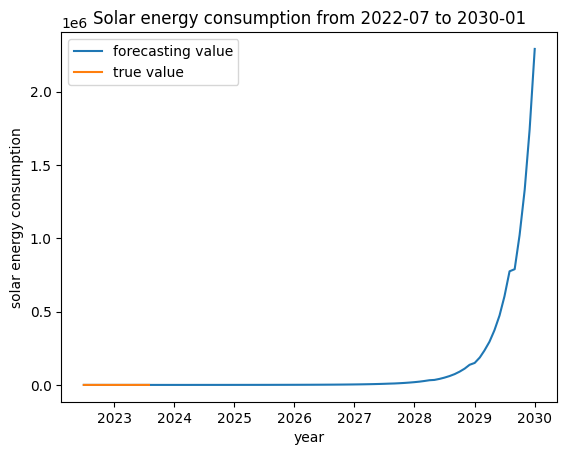

In [368]:
plt.plot(future_val[:"2030-01-01"],label="forecasting value")
plt.plot(testing_data['consumption'],label="true value")
plt.legend()
plt.title("Solar energy consumption from 2022-07 to 2030-01")
plt.xlabel("year")
plt.ylabel("solar energy consumption")

In [372]:
est_2030_01=future_val["2030-01-01"]

In [373]:
print(f"forcasted value for 2030-01 is {est_2030_01}")

forcasted value for 2030-01 is 2292431.182161522


In [374]:
times=future_val["2030-01-01"]/future_val["2023-01-01"]

In [375]:
print(f"the estimated solar energy consumption in 2023 is {times} times than solar energy consumption in 2023 ")

the estimated solar energy consumption in 2023 is 41245.381350032345 times than solar energy consumption in 2023 
